In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Vorstände - Einzeldaten

Tabelle mit konkreten Bezügen für Personen, die unterteilt sind in Grundgehalt und erfolgsabhängige Bezüge. Größtenteils für NRW. Dazu ausgewählte Sparkassen in Hessen und für andere Bundesländer

In [2]:
df = pd.read_csv('./data/jahresabschluss_vorstand.csv')
df_kerndaten = pd.read_csv('./data/jahresabschluss_kerndaten.csv')

## Wie hoch ist der Anteil erfolgsabhängiger Gehälter am Gesamtgehalt? 

Die erfolgsabhängigen Bezüge für einen Vorstand werden immer erst im nächsten Jahr ausgewiesen, daher gelten die Werte von `erfolgsabhaengige_bezuege` von 2014 für den Zeitraum von 2013, in dem diejenige Person im Vorstand war.

In [3]:
# convert to date
df.since = pd.to_datetime(df.since)
df.until = pd.to_datetime(df.until)

# set year
df['year'] = df.until.map(lambda x: x.year)

# get "feste_bezuege" of year before
def get_salary(row):
    if row.year == 2014:
        lookup = df[(df.name == row['name']) & (df.year == 2013)]
        if len(lookup) == 1:
            return lookup.iloc[0].feste_bezuege

df['feste_bezuege_2013'] = df.apply(get_salary, axis=1)

# calculate quota
df['bezuege_quote_zu_2013'] = df.erfolgsabhaengige_bezuege / df.feste_bezuege_2013

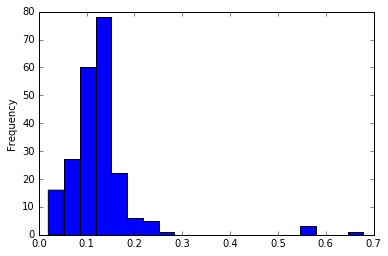

In [4]:
df_bezuege_quota = df[(df.bezuege_quote_zu_2013 > 0) & (df.year == 2014)]
df_bezuege_quota.bezuege_quote_zu_2013.plot.hist(bins=20)

## Gibt es Anteile, die auffällig hoch sind?

Empfehlung: nicht mehr als 15 %

### Wie viele sind über der Verbandsempfehlung?

In [5]:
len(df_bezuege_quota[df_bezuege_quota.bezuege_quote_zu_2013 > 0.15].index)

39

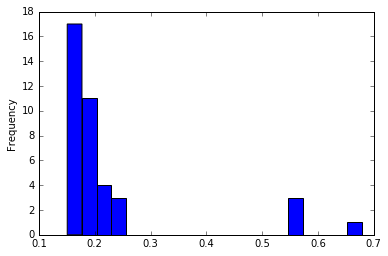

In [6]:
df_bezuege_quota[df_bezuege_quota.bezuege_quote_zu_2013 > 0.15].bezuege_quote_zu_2013.plot.hist(bins=20)

### Wer kriegt am meisten Bonus?

In [7]:
df_bezuege_quota[df_bezuege_quota.bezuege_quote_zu_2013 > 0.15].sort_values('bezuege_quote_zu_2013', ascending=False)[[
        'sparkasse',
        'name',
        'feste_bezuege',
        'erfolgsabhaengige_bezuege',
        'bezuege_quote_zu_2013'
    ]][:15]

,sparkasse,name,feste_bezuege,erfolgsabhaengige_bezuege,bezuege_quote_zu_2013
683,Frankfurter Sparkasse,Herbert Hans Grüntker,452000.0,300000.0,0.678733
681,Frankfurter Sparkasse,Stephan Bruhn,368000.0,200000.0,0.561798
678,Frankfurter Sparkasse,Altfried M. Lütkenhaus,363000.0,200000.0,0.560224
682,Frankfurter Sparkasse,Arne Weick,369000.0,200000.0,0.550964
341,Sparkasse Leverkusen,Manfred Herpolsheimer,416600.0,103000.0,0.255266
692,Sparkasse KölnBonn,Artur Grzesiek,590600.0,137500.0,0.232814
247,Sparkasse Märkisches Sauerland Hemer-Menden,Dietmar Tacke,348000.0,62000.0,0.230483
690,Sparkasse KölnBonn,Ulrich Voigt,409500.0,91700.0,0.223932
689,Sparkasse KölnBonn,Dr. Joachim Schmalzl,409500.0,91700.0,0.223932
688,Sparkasse KölnBonn,Dr. Christoph Siemons,409500.0,91700.0,0.223932


## Welche Sparkassen vergeben eine hohe Quote?

In [8]:
# groupy by sparkasse
df_bezuege_group = df_bezuege_quota[
    ['sparkasse', 'feste_bezuege_2013', 'erfolgsabhaengige_bezuege']
].groupby('sparkasse', as_index=False).sum()

# merge with sparkassen kerndaten data
df_spk = pd.merge(df_bezuege_group, df_kerndaten, on='sparkasse')

# calculate overall quota
df_spk['bezuege_quote_zu_2013'] = df_spk.erfolgsabhaengige_bezuege / df_spk.feste_bezuege_2013

# overview top 10
df_spk.sort_values('bezuege_quote_zu_2013', ascending=False)[
    ['sparkasse', 'feste_bezuege_2013', 'erfolgsabhaengige_bezuege', 'bezuege_quote_zu_2013']
][:10]

,sparkasse,feste_bezuege_2013,erfolgsabhaengige_bezuege,bezuege_quote_zu_2013
0,Frankfurter Sparkasse,1518000.0,900000.0,0.592885
38,Sparkasse KölnBonn,1819100.0,412600.0,0.226815
60,Stadt- und Kreissparkasse Darmstadt,1031000.0,195000.0,0.189137
52,Sparkasse Starkenburg,490000.0,92000.0,0.187755
40,Sparkasse Leverkusen,964200.0,176700.0,0.183261
18,Sparkasse Dieburg,604000.0,108900.0,0.180298
32,Sparkasse Hanau,802000.0,142000.0,0.177057
43,Sparkasse Märkisches Sauerland Hemer-Menden,495000.0,87000.0,0.175758
25,Sparkasse Gießen,471000.0,82000.0,0.174098
1,Kasseler Sparkasse,1027000.0,178000.0,0.173320


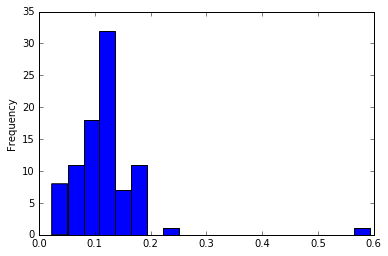

In [9]:
df_spk.bezuege_quote_zu_2013.plot.hist(bins=20)

## Wie unterscheidet sich diese Quote zwischen den Sparkassenverbänden?

In [10]:
df_asso_states = pd.merge(df_bezuege_group, 
                   df_kerndaten[['sparkasse', 'anzahl_vorstaende_2013', 'verband', 'state']],
                   on='sparkasse')

df_asso_group = df_asso_states.groupby('verband', as_index=False).sum()

# get data per board member
df_asso_group['verguetung_per_member'] = df_asso_group.feste_bezuege_2013 / df_asso_group.anzahl_vorstaende_2013
df_asso_group['bezuege_per_member'] = df_asso_group.erfolgsabhaengige_bezuege / df_asso_group.anzahl_vorstaende_2013
df_asso_group['per_member_quota'] = df_asso_group.bezuege_per_member / df_asso_group.verguetung_per_member

df_asso_group

,verband,feste_bezuege_2013,erfolgsabhaengige_bezuege,anzahl_vorstaende_2013,verguetung_per_member,bezuege_per_member,per_member_quota
0,RSGV,18855427.0,2350180.0,57.50,327920.469565,40872.695652,0.124642
1,SGVHT,14026000.0,2783900.0,57.90,242245.250432,48081.174439,0.198481
2,SVB,1610168.0,223319.0,5.30,303805.283019,42135.660377,0.138693
3,SVWL,29187700.0,3030400.0,109.81,265801.839541,27596.758037,0.103825


## Wie unterscheidet sich diese Quote zwischen den Bundesländern?

In [11]:
df_state_group = df_asso_states.groupby('state', as_index=False).sum()

# get data per board member
df_state_group['verguetung_per_member'] = df_state_group.feste_bezuege_2013 / df_state_group.anzahl_vorstaende_2013
df_state_group['bezuege_per_member'] = df_state_group.erfolgsabhaengige_bezuege / df_state_group.anzahl_vorstaende_2013
df_state_group['per_member_quota'] = df_state_group.bezuege_per_member / df_state_group.verguetung_per_member

df_state_group

,state,feste_bezuege_2013,erfolgsabhaengige_bezuege,anzahl_vorstaende_2013,verguetung_per_member,bezuege_per_member,per_member_quota
0,Bayern,1610168.0,223319.0,5.30,303805.283019,42135.660377,0.138693
1,Hessen,14026000.0,2783900.0,57.90,242245.250432,48081.174439,0.198481
2,Nordrhein-Westfalen,48043127.0,5380580.0,167.31,287150.361604,32159.344929,0.111995
